# Analysis of HCI Alt Text Dataset

This notebook includes all analysis scripts used to analyze and generate plots for the ASSETS 2022 paper "A Dataset of Alt Texts from HCI Publications: Analyses and Uses Towards Producing More Description Alt Texts of Data Visualizations in Scientific Papers."

In [1]:
import os
import json
import csv
import gzip
import itertools
from collections import defaultdict, Counter
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
from cycler import cycler
from typing import List
import seaborn as sns
from pandas import DataFrame
import pandas as pd
import matplotlib as mpl
from matplotlib.patches import Patch
import spacy
import random
from scipy.stats import sem

nlp = spacy.load("en_core_sci_sm")

# The dataset is expected to be located at `data/hci-alt-text-dataset-20220915.jsonl`
DATA_FILE = '../data/hci-alt-text-dataset-20220915.jsonl'

# If saving plots, specify output directory and uncomment
# OUTPUT_DIR = '../plots'
# os.makedirs(OUTPUT_DIR, exist_ok=True)

# Plotting colors
tableau20 = [
    (31, 119, 180), (255, 127, 14), (255, 187, 120),
    (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),
    (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),
    (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),
    (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)
]

# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.
for i in range(len(tableau20)):
    r, g, b = tableau20[i]
    tableau20[i] = (r / 255., g / 255., b / 255.)

# Tableau Color Blind 10
tableau20blind = [(0, 107, 164), (255, 128, 14), (171, 171, 171), (89, 89, 89),
             (95, 158, 209), (200, 82, 0), (137, 137, 137), (163, 200, 236),
             (255, 188, 121), (207, 207, 207)]

# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.
for i in range(len(tableau20blind)):
    r, g, b = tableau20blind[i]
    tableau20blind[i] = (r / 255., g / 255., b / 255.)
    
# Color-line cycler
cycler_cl = cycler('linestyle', ['-', '--', ':', '-.', '-', '--']) * cycler('color', tableau20blind)

# flatten list of lists
def flatten(l: List) -> List:
    return [item for sublist in l for item in sublist]

In [2]:
# Load the dataset
data = []
with open(DATA_FILE, 'r') as f:
    for line in f:
        data.append(json.loads(line))
    
print(f'Entries: {len(data)}')


Entries: 3006


In [3]:
data[0]

{'title': 'Towards Efficacy-Centered Game Design Patterns For Brain Injury Rehabilitation: A Data-Driven Approach',
 'pdf_hash': 'b48bf288b652f156808e742c91199ca1e93885f2',
 'year': 2015,
 'venue': 'ASSETS',
 'alt_text': 'A case includes information about session gaols, patient attributes, game attributes, and session outcomes.',
 'levels': None,
 'corpus_id': 14308372,
 'sentences': ['A case includes information about session gaols, patient attributes, game attributes, and session outcomes.'],
 'caption': 'Figure 1. Summary attributes of a case',
 'local_uri': ['b48bf288b652f156808e742c91199ca1e93885f2_Image_001.jpg'],
 'annotated': False,
 'compound': False}

## Analyzing alt text quantity over time

In [4]:
# Load alt text count data
year = []
alttext_okay = []
total = []
with open('../data/pdf_alttext_success.csv', 'r') as f:
    reader = csv.reader(f)
    next(reader)
    for y, a, t in reader:
        if int(y) > 2009:
            year.append(int(y))
            alttext_okay.append(int(a))
            total.append(int(t))

# Bootstrap alt text proportion errors            
bootstrap_n = 1000
bs_mean = []
bs_stdev = []

print('=== BOOTSTRAPPING ===')
for y, a, t in zip(year, alttext_okay, total):
    print(y)
    population = [1]*a + [0]*(t - a)
    bootstrap_props = []
    for b_iter in range(bootstrap_n):
        sample = random.choices(population, k=t)
        prop = sum(sample) / t
        bootstrap_props.append(prop)
    bs_mean.append(np.mean(bootstrap_props))
    bs_stdev.append(np.std(bootstrap_props))

bs_sterr = [std / np.sqrt(bootstrap_n) for std in bs_stdev]
  
df = pd.DataFrame(
    zip(year, alttext_okay, total, bs_mean, bs_stdev, bs_sterr), 
    columns = ['Year', 'Alttext_okay', 'Total', 'BS_mean', 'BS_stdev', 'BS_sterr']
)
    
df['Proportion w/ alt-text'] = df['Alttext_okay'] / df['Total']

display(df)


=== BOOTSTRAPPING ===
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021


,Year,Alttext_okay,Total,BS_mean,BS_stdev,BS_sterr,Proportion w/ alt-text
0,2010,14,1894,0.007344,0.001939,0.000061,0.007392
1,2011,9,2068,0.004348,0.001466,0.000046,0.004352
2,2012,12,2101,0.005749,0.001624,0.000051,0.005712
3,2013,22,2151,0.010140,0.002204,0.000070,0.010228
4,2014,80,2303,0.034719,0.003913,0.000124,0.034737
5,2015,75,2367,0.031768,0.003492,0.000110,0.031686
6,2016,60,2409,0.024942,0.003151,0.000100,0.024907
7,2017,88,2376,0.037120,0.003952,0.000125,0.037037
8,2018,111,2447,0.045485,0.004124,0.000130,0.045362
9,2019,123,2432,0.050654,0.004282,0.000135,0.050576


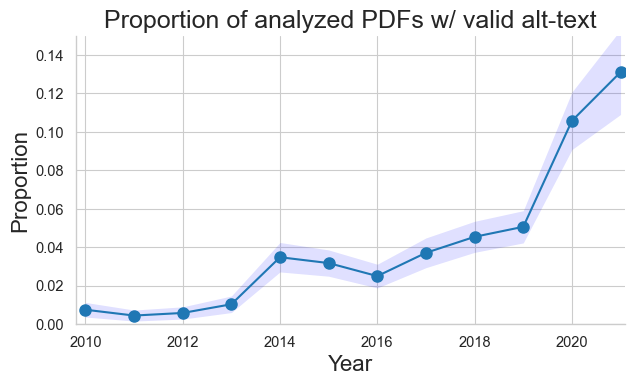

In [5]:
###### Plot alt text over time
plt.close()
sns.set_context("paper", font_scale=1.2)
sns.set_style("whitegrid")

f, ax = plt.subplots(figsize = (6.5, 4))
sns.set_color_codes('muted')
ax.plot(df['Year'], df['Proportion w/ alt-text'], color='tab:blue', linewidth=1.5, marker='o', markersize=8)
ax.fill_between(df['Year'], df['Proportion w/ alt-text']-1.96*df['BS_stdev'], df['Proportion w/ alt-text']+1.96*df['BS_stdev'],
    alpha=0.12, edgecolor='blue', facecolor='blue',
    linewidth=0)

# Iterate thorugh each axis
ax.set_title('Proportion of analyzed PDFs w/ valid alt-text', fontsize=18)
ax.set_xlabel('Year', fontsize=16)
ax.set_ylabel('Proportion', fontsize=16)
ax.set_xlim((2009.8, 2021.1))
ax.set_ylim((0, 0.15))
# ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

# plt.savefig(os.path.join(OUTPUT_DIR, 'alttext_over_time.png'))

## Analyzing semantic levels of alt text

In [6]:
# Display information about number and distribution of semantic levels in annotation data
max_levels = []
num_levels = []

img_levels = [entry['levels'] for entry in data if entry['levels']]
for levels in img_levels:
    flat_levels = flatten(levels)
    max_level = max(flat_levels)
    if max_level >= 0:
        max_levels.append(max_level)
    if set(flat_levels) != {-1}:
        num_levels.append(len(set([l for l in flat_levels if l >= 1])))
    
print('=== Max levels ===')
max_counts = Counter(max_levels)
for k in range(0, 5):
    print(f'{k}: {max_counts[k]}')

print()
print('=== Number of unique levels ===')
num_counts = Counter(num_levels)
for k in range(0, 5):
    print(f'{k}: {num_counts[k]}')
    

=== Max levels ===
0: 5
1: 181
2: 169
3: 149
4: 8

=== Number of unique levels ===
0: 5
1: 194
2: 239
3: 71
4: 3


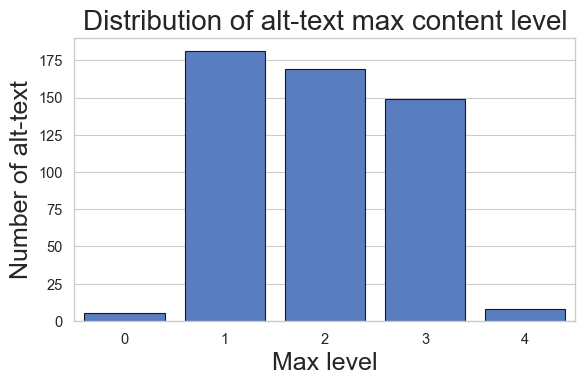

In [7]:
## Plot distribution of max levels
df = pd.DataFrame.from_dict(max_counts, orient='index').reset_index()
df = df.rename(columns={0: "max"})

plt.close()
sns.set_context("paper", font_scale=1.2)
sns.set_style("whitegrid")

f, ax = plt.subplots(figsize = (6, 4))
sns.set_color_codes('muted')
sns.barplot(x = 'index', y = 'max', data = df,
            label = 'Max level', color = 'b', edgecolor = 'k')

# Iterate thorugh each axis
ax.set_title('Distribution of alt-text max content level', fontsize=20)
ax.set_xlabel('Max level', fontsize=18)
ax.set_ylabel('Number of alt-text', fontsize=18)

plt.tight_layout()
plt.show()

# plt.savefig(os.path.join(OUTPUT_DIR, 'max_alt_text_level.png'))


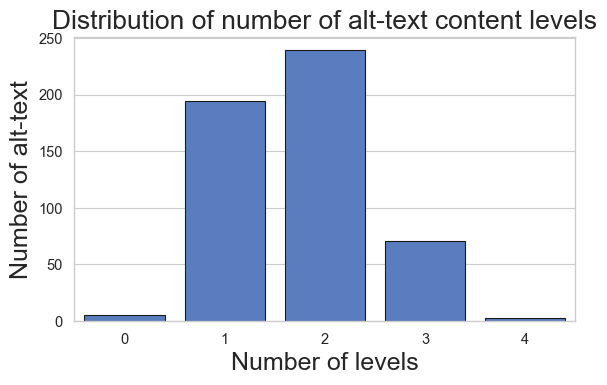

In [8]:
# Plot distribution of number of levels
df = pd.DataFrame.from_dict(num_counts, orient='index').reset_index()
df = df.rename(columns={0: "num"})

plt.close()
sns.set_context("paper", font_scale=1.2)
sns.set_style("whitegrid")

f, ax = plt.subplots(figsize = (6, 4))
sns.set_color_codes('muted')
sns.barplot(x = 'index', y = 'num', data = df,
            label = 'Number of levels', color = 'b', edgecolor = 'k')

# Iterate thorugh each axis
ax.set_title('Distribution of number of alt-text content levels', fontsize=19)
ax.set_xlabel('Number of levels', fontsize=18)
ax.set_ylabel('Number of alt-text', fontsize=18)

plt.tight_layout()
plt.show()

# plt.savefig(os.path.join(OUTPUT_DIR, 'number_of_alt_text_levels.png'))


## Length of alt text versus semantic levels

In [9]:
# Get alt text length and number of levels present
levels_and_alttext = [(entry['levels'], entry['alt_text']) for entry in data if entry['levels']]
alttext_len_and_level = []
for levels, alttext in levels_and_alttext:
    flat_levels = flatten(levels)
    if set(flat_levels) != {-1}:
        num_levels = len(set([l for l in flat_levels if l >= 1]))
        alttext_len_and_level.append((num_levels, len(alttext)))   

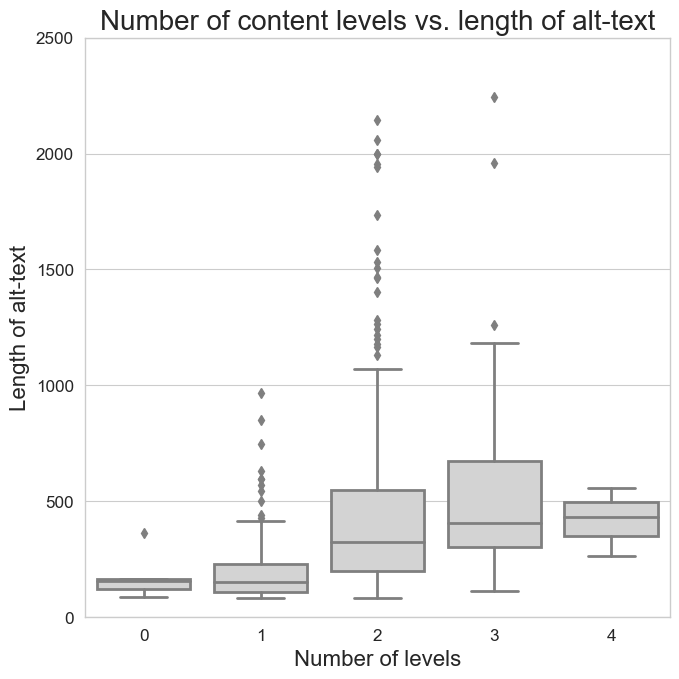

In [10]:
# Plot distribution of levels by length
df = pd.DataFrame(alttext_len_and_level, columns=['Number of levels', 'Length'])

plt.close()
sns.set_context("paper", font_scale=1.4)
sns.set_style("whitegrid")

f, ax = plt.subplots(figsize = (7, 7))
sns.set_color_codes('muted')
ax = sns.boxplot(x="Number of levels", y="Length", color='lightgray', linewidth=2, data=df)

# Iterate thorugh each axis
ax.set_title('Number of content levels vs. length of alt-text', fontsize=20)
ax.set_xlabel('Number of levels', fontsize=16)
ax.set_ylabel('Length of alt-text', fontsize=16)
ax.set_ylim([0, 2500])

plt.tight_layout()
plt.show()

# plt.savefig(os.path.join(OUTPUT_DIR, 'alt_text_level_by_length.png'))


## Semantic levels proportions over time

In [11]:
# get distribution of levels per year
levels_by_year = defaultdict(lambda: defaultdict(list))

annotated_figures = [entry for entry in data if entry['annotated'] and entry.get('is_plot')]

for entry in annotated_figures:
    for lvl in range(1, 5):
        if lvl in entry['uniq_levels']:
            levels_by_year[lvl][entry['year']].append(1)
        else:
            levels_by_year[lvl][entry['year']].append(0)
            
# Bootstrap errors            
bootstrap_n = 1000

print('Bootstrapping errors...')
plot_values = []
for lvl in levels_by_year:
    print(f'level: {lvl}')
    for yr in range(2010, 2022):
        population = levels_by_year[lvl][yr]
        lvl_ok = len([c for c in population if c])
        total = len(population)
        prop_ok = lvl_ok / total
        bootstrap_props = []
        for b_iter in range(bootstrap_n):
            sample = random.choices(population, k=total)
            prop = sum(sample) / total
            bootstrap_props.append(prop)
        bs_mean = np.mean(bootstrap_props)
        bs_stdev = np.std(bootstrap_props)
        bs_sterr = bs_stdev / np.sqrt(bootstrap_n)
        plot_values.append((lvl, yr, lvl_ok, total, prop_ok, bs_stdev, bs_sterr))
        
df = pd.DataFrame(
    plot_values, 
    columns = ['Level', 'Year', 'Level exists', 'Total', 'Proportion with level', 'BS_stdev', 'BS_sterr']
)
        
        

Bootstrapping errors...
level: 1
level: 2
level: 3
level: 4


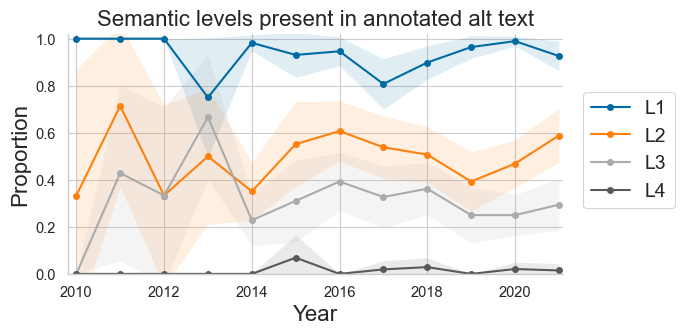

In [12]:
# Plot levels over time
plt.close()
sns.set_context("paper", font_scale=1.2)
sns.set_style("whitegrid")

f, ax = plt.subplots(figsize = (7, 3.5))
sns.set_color_codes('muted')
lines = []
for lvl in range(1, 5):
    df_lvl = df.loc[df['Level'] == lvl]
    ax.plot(
        df_lvl['Year'], 
        df_lvl['Proportion with level'], 
        marker='o', markersize=4, 
        linewidth=1.5, color=tableau20blind[lvl-1],
        label=f'L{lvl}'
    )
    ax.fill_between(
        df_lvl['Year'], 
        df_lvl['Proportion with level']-1.96*df_lvl['BS_stdev'], 
        df_lvl['Proportion with level']+1.96*df_lvl['BS_stdev'],
        alpha=0.12, 
        edgecolor=tableau20blind[lvl-1], 
        facecolor=tableau20blind[lvl-1],
        linewidth=0
    )

# Iterate thorugh each axis
ax.set_title('Semantic levels present in annotated alt text', fontsize=16)
ax.set_xlabel('Year', fontsize=16)
ax.set_ylabel('Proportion', fontsize=16)
ax.set_xlim((2009.8, 2021.1))
ax.set_ylim((0, 1.02))
# ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend(bbox_to_anchor=(1.02, 0.8), ncol=1, fontsize=14)

plt.tight_layout()
plt.show()

# plt.savefig(os.path.join(OUTPUT_DIR, 'semantic_levels_over_time.png'))